### Task 0: Read dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.special import comb

In [2]:
dataset = pd.read_csv("spiral-dataset.csv", delimiter='\t', header = None)
print(dataset.shape)
dataset.head()
print(dataset[0:5])

(312, 3)
       0     1  2
0  31.95  7.95  3
1  31.15  7.30  3
2  30.45  6.65  3
3  29.70  6.00  3
4  28.90  5.55  3


### TASK 1: # (20 pts) Generate a figure from the given dataset that resembles Figure 1.

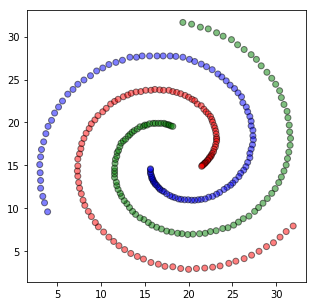

In [3]:
def plotDataset(df):
    colors = []
    colors = np.where(df['label']==1,'g','-')
    colors[df['label']==2] = 'b'
    colors[df['label']==3] = 'r'
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(df['x'], df['y'], color=colors, alpha=0.5, edgecolor='k')
    plt.show()
    
dataset = pd.DataFrame(dict(x=dataset.iloc[:,0], y=dataset.iloc[:,1], label=dataset.iloc[:,2]))    
plotDataset(dataset)

### TASK 2:  (40 pts) Implement the k-means clustering algorithm. 

In [4]:
def k_meanClustering(df, k, ctrColors):
    #Select k points randomly
    #centroids[i] = [x, y]
    centroidPoints = {
        i+1: [np.random.randint(0, 50), np.random.randint(0, 50)]
        for i in range(k)
    }
    oldCentroids = {
        i+1: [0, 0]
        for i in range(k)
    }   
    # Error func. - Distance between new centroids and old centroids
    for i in centroidPoints.keys():
        error = np.sqrt(
                    (oldCentroids[i][0] - centroidPoints[i][0]) ** 2
                    + (oldCentroids[i][1] - centroidPoints[i][1]) ** 2
                )
    # Loop will run till the error becomes zero
    step = 0
    while (not np.array_equal(centroidPoints, oldCentroids)):
        #Form k clusters by assigning all points to the closest centroid
        df = assignment(df, centroidPoints, ctrColors)
        #Storing the old centroid values
        oldCentroids = copy.deepcopy(centroidPoints)
        #Recompute centroids of each cluster
        centroidPoints = update(df, centroidPoints)
        step = step + 1
    return centroidPoints, df  
    
def assignment(df, centroidPoints, ctrColors):
    #Calculate the distance between each point with centroids 
    df = pd.DataFrame(dict(x=df.iloc[:,0], y=df.iloc[:,1], label=df.iloc[:,2])) 
    for i in centroidPoints.keys():
        df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (df['x'] - centroidPoints[i][0]) ** 2
                + (df['y'] - centroidPoints[i][1]) ** 2
            )
        )
    #Get the min distance and add column 'closest'   
    dist_cols = ['distance_from_{}'.format(i) for i in centroidPoints.keys()]
    new = df.loc[:, dist_cols].idxmin(axis=1, skipna = True)
    df['closest'] = new
    #Change the column closest to the closest centroid id
    format = lambda x: int(x.lstrip('distance_from_'))
    df['closest'] = df['closest'].map(format)
    #Add the color column which is the color of the closest centroid
    format = lambda x: ctrColors[x]
    df['color'] = df['closest'].map(format)
    return df

def update(df, centroidPoints):
    for i in centroidPoints.keys():
        centroidPoints[i][0] = np.mean(df[df['closest'] == i]['x'])
        centroidPoints[i][1] = np.mean(df[df['closest'] == i]['y'])
    return centroidPoints

def plotDatasetWithCentroids(df, centroidPoints,ctrColors):
    #df = pd.DataFrame(dict(x=df.iloc[:,0], y=df.iloc[:,1], label=df.iloc[:,2])) 
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(df['x'], df['y'], color=df['color'], alpha=0.5, edgecolor='k')
    for i in centroidPoints.keys():
        plt.scatter(*centroidPoints[i], color=ctrColors[i])
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.show()


### 2.a)  Run your k-means algorithm on the given dataset setting the value k=3 

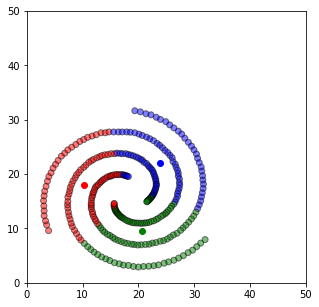

In [5]:
#Initialize k and color map for k
k = 3
colmap = {1: 'r', 2: 'g', 3: 'b'}
#Do k-meanClustering
centroids, dataset = k_meanClustering(dataset, k, colmap)
#Re plot dataset with centroids
plotDatasetWithCentroids(dataset, centroids, colmap)


### 2.b) Compute the intrinsic performance metric: Sum of Squared Error, SSE (smaller the better), and the extrinsic performance metric: Rand-Index, RI (higher the better)

In [6]:
def addDistCol(df, centroidPoints):
    for i in centroidPoints.keys():
        #Get the min distance and add column 'dist_point_ctr'   
        dist_cols = ['distance_from_{}'.format(i) for i in centroidPoints.keys()]
        new = df.loc[:, dist_cols].min(axis=1, skipna = True)
        df['dist_point_ctr'] = new
    return df

def calSSE(df):
    sse = 0
    for i in range(len(df)):
        row = df.iloc[i]
        sse += row['dist_point_ctr']**2 
    return sse

def rand_index_score(clusters, classes):

    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

SSEs = []
RIs = []
dataset = addDistCol(dataset,centroids)
SSE = calSSE(dataset)
SSEs.append(SSE)
RI = rand_index_score(dataset['closest'], dataset['label'])
RIs.append(RI)  
print("SSEs: ", SSEs)
print("RIs: ", RIs)

SSEs:  [12313.275106261695]
RIs:  [0.5542913677961909]


### 2.c) Repeat Task (2.a) & (2.b) another 9 (nine) times

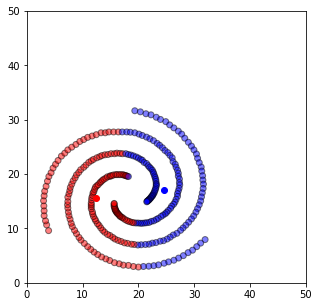

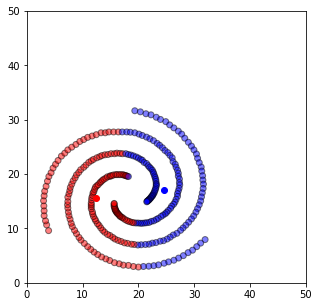

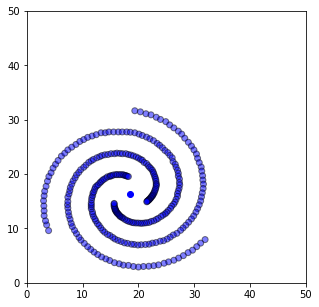

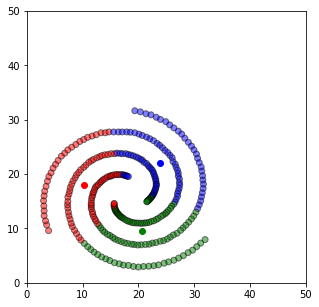

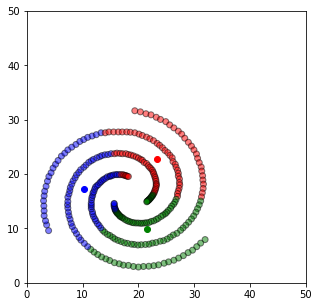

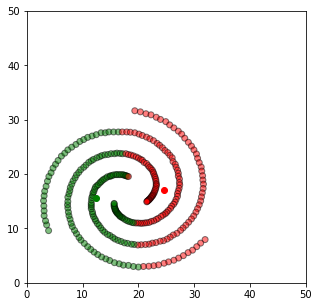

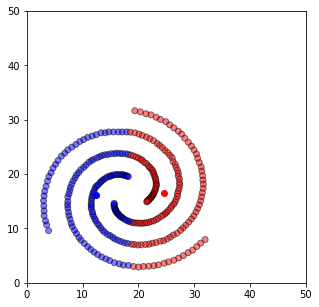

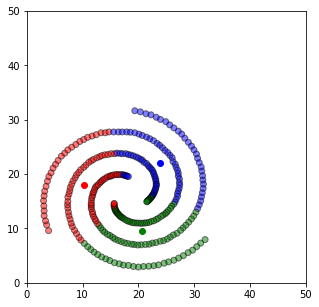

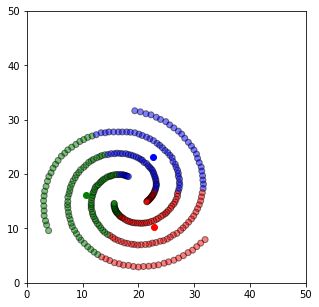

SSEs:  [12313.275106261695, 19580.52250986356, 19580.52250986356, 31239.250432692275, 12313.275106261695, 12288.43208551329, 19580.52250986356, 19586.77714588041, 12313.275106261695, 12313.900175402778]
RIs:  [0.5542913677961909, 0.49882512985406874, 0.49882512985406874, 0.3313339929095556, 0.5542913677961909, 0.5540028031989447, 0.49882512985406874, 0.4988045180971226, 0.5542913677961909, 0.554044026712837]
Best SSE:  12288.43208551329
Best RI:  0.5542913677961909


In [8]:
for i in range(9):
    #Do k-meanClustering
    centroids, dataset = k_meanClustering(dataset, k, colmap)
    #Re plot dataset with centroids
    plotDatasetWithCentroids(dataset, centroids, colmap)
    dataset = addDistCol(dataset,centroids)
    SSE = calSSE(dataset)
    SSEs.append(SSE)
    RI = rand_index_score(dataset['closest'], dataset['label'])
    RIs.append(RI)   

print("SSEs: ", SSEs)
print("RIs: ", RIs)
print("Best SSE: ", np.array(SSEs).min())
print("Best RI: ", np.array(RIs).max())

## Task 3: (40 pts) Implement the Hierarchical clustering algorithm. 

In [11]:
def get_centroid(cluster):
    temp = np.reshape(cluster, (len(cluster),2))
    x_avg = np.mean(cluster[:,0])
    y_avg = np.mean(cluster[:,1])
    return np.array([x_avg, y_avg])
    
def cluster_distance(a, b, mode):
    # a is a list of points
    # b is a list of points
    dist = 0
    if(mode == 'CEN'):
        centroid_a = get_centroid(a)
        centroid_b = get_centroid(b)
        dist = distance(centroid_a, centroid_b, ax=0)
    return dist


def cluster_distances(cluster, clusters, mode):
    if(mode == 'MIN'):
        for a in cluster:
            distances = []
            for other in clusters:
                temp = []
                for b in other:
                    temp.append(distance(a, b, ax=0))
            distances=min(temp)
    if(mode == 'CEN'):
        distances = []
        for other in clusters:
            distances.append(cluster_distance(cluster, other, mode))
        print(distances)
        return distances       
                
def proximity_matrix(d):
    mat = np.zeros(len(d)**2)
    mat = np.reshape(mat, (len(d), len(d)))
    for i in range(len(mat)):
        distances = cluster_distances(d[i], d[i:], mode)
        #print(distances)
        for j in range(len(distances)):
            mat[i][j+i] = distances[j]
            mat[j+i][i] = distances[j]
    return mat

    
mode = 'MIN'
mode = 'MAX'
mode = 'AVG'
mode = 'CEN'

print(dataset[0:5])
x_y_data = [dataset.iloc[:, 0], dataset.iloc[:,1]]
clusters = np.matrix(x_y_data)

#while(len(d) > 3):
# FIRST GET d is a list of clusters
matrix = proximity_matrix(clusters)
print(matrix)
minimum = matrix[matrix != 0].min()
close_clusters = np.where(matrix == minimum)[0]
new_cluster = []
c1 = clusters[close_clusters[0]]
c2 = clusters[close_clusters[1]]
for p in c1:
    new_cluster.append(list(np.array(p).reshape(-1,)))
for p in c2:
    new_cluster.append(list(np.array(p).reshape(-1,)))   

# GET SMALLEST DIST
# UPDATE the list of clusters
#del clusters[close_clusters[0]]
#del clusters[close_clusters[1]]
#clusters.append(new_cluster)

       x     y  label  distance_from_1  distance_from_2  distance_from_3  \
0  31.95  7.95      3         9.490367        22.902902        17.868504   
1  31.15  7.30      3         8.904765        22.407948        18.033427   
2  30.45  6.65      3         8.495988        22.040387        18.297775   
3  29.70  6.00      3         8.135982        21.664522        18.588334   
4  28.90  5.55      3         7.723917        21.184096        18.721352   

   closest color  dist_point_ctr  
0        1     r        9.490367  
1        1     r        8.904765  
2        1     r        8.495988  
3        1     r        8.135982  
4        1     r        7.723917  


ValueError: cannot reshape array of size 312 into shape (1,2)